In [2]:
import xarray as xr
from pathlib import Path
import os

%matplotlib inline

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

from src import preprocess
preprocess.__all__

['VHIPreprocessor',
 'CHIRPSPreprocessor',
 'PlanetOSPreprocessor',
 'GLEAMPreprocessor',
 'ERA5MonthlyMeanPreprocessor',
 'ESACCIPreprocessor',
 'SRTMPreprocessor',
 'KenyaAdminPreprocessor']

# Preprocessors

The `Preprocessors` taking data from the `data/raw` directory and writing to the `data/interim` directory.

These `Preprocessors` perform a number of tasks:
- Put the data on a regular spatial grid
- Put the data on a consistent temporal frequency (e.g. all data is converted to `monthly` timesteps)
- Dimension names are standardized (`time, lat, lon`)
- The same areal extend (by default Kenya is subset from the data).

<img src="img/preprocess_diagram.png" style='background-color: #878787; border-radius: 25px; padding: 20px'>

The preprocessors offer an opportunity to tailor the pipeline to your own needs. You can easily change the area to be subset (the Region of Interest - ROI) for example.

The preprocessors do a very useful task in making the data consistent. Working with a Unified Data Format is useful for many comparison tasks and is essential for training machine learning and staitistical models. 

**NOTE**: There is a bug with using the [`XESMF` Package]() that requires you to unload other libraries using netcdf functionality. See 
[here](https://github.com/JiaweiZhuang/xESMF/issues/55) and [here](https://github.com/esowc/ml_drought/issues/71). The very hacky fix we have found:

Type this into the shell before running the preprocessors.
```shell
LD_LIBRARY_PATH=''
```

## Preprocessor API

The main entry point to the preprocessors is through the `prerprocessor.preprocess()` function.

Regridding the data requires you to have a reference `.nc` file that you want to use as the reference grid. This means that your data will be put onto the same `lat, lon` grid as the reference file.

In [3]:
preprocessor = preprocess.ERA5MonthlyMeanPreprocessor()

[method for method in dir(preprocessor) if '__' not in method]

['_preprocess_single',
 'analysis',
 'chop_roi',
 'create_filename',
 'data_folder',
 'dataset',
 'filter_outfiles',
 'get_filepaths',
 'interim',
 'load_reference_grid',
 'merge_files',
 'out_dir',
 'preprocess',
 'preprocessed_folder',
 'raw_folder',
 'regrid',
 'resample_time',
 'static',
 'static_vars']

In [4]:
help(preprocessor.preprocess)

Help on method preprocess in module src.preprocess.era5:

preprocess(subset_str: Union[str, NoneType] = 'kenya', regrid: Union[pathlib.Path, NoneType] = None, resample_time: Union[str, NoneType] = 'M', upsampling: bool = False, parallel: bool = False, cleanup: bool = True) -> None method of src.preprocess.era5.ERA5MonthlyMeanPreprocessor instance
    Preprocess all of the era5 POS .nc files to produce
    one subset file.
    
    Arguments
    ----------
    subset_str: Optional[str] = 'kenya'
        Whether to subset Kenya when preprocessing
    regrid: Optional[Path] = None
        If a Path is passed, the CHIRPS files will be regridded to have the same
        grid as the dataset at that Path. If None, no regridding happens
    resample_time: str = 'M'
        If not None, defines the time length to which the data will be resampled
    upsampling: bool = False
        If true, tells the class the time-sampling will be upsampling. In this case,
        nearest instead of mean is us

In [5]:
preprocessor.preprocess(subset_str='kenya', regrid=None)

Reading data from data/raw. Writing to data/interim/reanalysis-era5-single-levels-monthly-means_interim
Processing 01.nc
selecting region: kenya from ds
Saving to data/interim/reanalysis-era5-single-levels-monthly-means_interim/2010_01_total_precipitation_kenya.nc
Done for ERA5 01.nc

**** data/interim/reanalysis-era5-single-levels-monthly-means_preprocessed/data_kenya.nc Created! ****

[]


/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)
/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


In [6]:
data_dir = Path('data')
ds = xr.open_dataset(data_dir / 'interim' / 'reanalysis-era5-single-levels-monthly-means_preprocessed' / 'reanalysis-era5-single-levels-monthly-means_kenya.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-31
  * lon      (lon) float32 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
Data variables:
    tp       (time, lat, lon) float32 ...

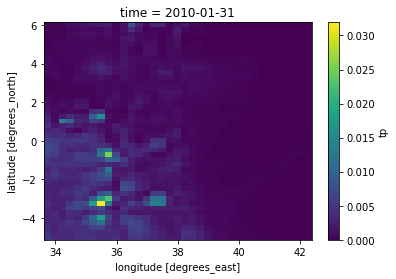

In [7]:
ds.tp.plot()

### VHI Preprocessor

The raw VHI data has a number of peculiarities:
- It is global
- `lat, lon` are stored as `HEIGHT, WIDTH`
- 

In [8]:
preprocessor = preprocess.VHIPreprocessor()
help(preprocessor.preprocess)

Help on method preprocess in module src.preprocess.vhi:

preprocess(subset_str: Union[str, NoneType] = 'kenya', regrid: Union[pathlib.Path, NoneType] = None, n_parallel_processes: int = 1, resample_time: Union[str, NoneType] = 'M', upsampling: bool = False, cleanup: bool = True) -> None method of src.preprocess.vhi.VHIPreprocessor instance
    Preprocess all of the NOAA VHI .nc files to produce
    one subset file with consistent lat/lon and timestamps.
    
    Run in parallel if n_parallel_processes > 1
    
    Arguments
    ----------
    subset_str: Optional[str] = 'kenya'
        Region to subset. Currently valid: {'kenya', 'ethiopia', 'east_africa'}
    regrid: Optional[Path] = None
        If a Path is passed, the VHI files will be regridded to have the same
        grid as the dataset at that Path. If None, no regridding happens
    resample_time: str = 'M'
        If not None, defines the time length to which the data will be resampled
    upsampling: bool = False
        If 

### BEFORE preprocess


In [9]:
!ls data/raw/vhi/2015

VHP.G04.C07.npp.P2015001.VH.nc VHP.G04.C07.npp.P2015003.VH.nc
VHP.G04.C07.npp.P2015002.VH.nc VHP.G04.C07.npp.P2015004.VH.nc


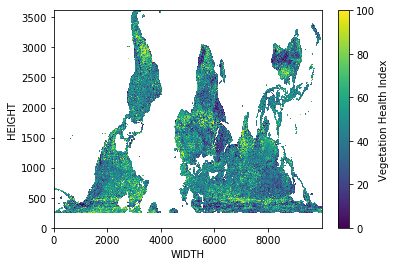

In [10]:
before = xr.open_dataset(data_dir / 'raw' / 'vhi' / '2015' / 'VHP.G04.C07.npp.P2015001.VH.nc')
before.VHI.plot()

In [11]:
before

<xarray.Dataset>
Dimensions:       (HEIGHT: 3616, WIDTH: 10000)
Dimensions without coordinates: HEIGHT, WIDTH
Data variables:
    VCI           (HEIGHT, WIDTH) float32 ...
    TCI           (HEIGHT, WIDTH) float32 ...
    VHI           (HEIGHT, WIDTH) float32 ...
    QA            (HEIGHT, WIDTH) float32 ...
    PLATE_CARREE  int32 ...
Attributes:
    Conventions:               CF-1.5
    Metadata_Conventions:      CF-1.5, Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (version 17, 24 March 2...
    project:                   S-NPP Data Exploitation
    institution:               DOC/NOAA/NESDIS/NDE > S-NPP Data Exploitation,...
    naming_authority:          gov.noaa.nesdis.nde
    instrument_name:           VIIRS
    summary:                   Vegetation Health Product
    history:                   Version 1
    processing_level:          NOAA Level 3
    source:                    VIIRS-I1-SDR, VIIRS-I2-SDR, VIIRS-I5-SDR, ICCMO
    references: 

### AFTER preprocess

In [ ]:
data_dir = Path('data')
regrid_data_path = data_dir / 'interim' / 'reanalysis-era5-single-levels-monthly-means_preprocessed' / 'reanalysis-era5-single-levels-monthly-means_kenya.nc'
preprocessor.preprocess(subset_str='kenya', regrid=regrid_data_path, cleanup=False)

Reading data from data/raw.             Writing to data/interim/VHI_interim
Starting work on data/raw/vhi/1981/VHP.G04.C07.NC.P1981035.VH.nc
Starting work on VHP.G04.C07.NC.P1981035.VH.nc
### FAILED: data/raw/vhi/1981/VHP.G04.C07.NC.P1981035.VH.nc
Starting work on data/raw/vhi/1985/VHP.G04.C07.NF.P1985038.VH.nc
Starting work on VHP.G04.C07.NF.P1985038.VH.nc
### FAILED: data/raw/vhi/1985/VHP.G04.C07.NF.P1985038.VH.nc
Starting work on data/raw/vhi/1989/VHP.G04.C07.NH.P1989030.VH.nc
Starting work on VHP.G04.C07.NH.P1989030.VH.nc
### FAILED: data/raw/vhi/1989/VHP.G04.C07.NH.P1989030.VH.nc
Starting work on data/raw/vhi/1993/VHP.G04.C07.NH.P1993022.VH.nc
Starting work on VHP.G04.C07.NH.P1993022.VH.nc
### FAILED: data/raw/vhi/1993/VHP.G04.C07.NH.P1993022.VH.nc
Starting work on data/raw/vhi/2015/VHP.G04.C07.npp.P2015001.VH.nc
Starting work on VHP.G04.C07.npp.P2015001.VH.nc


TODO:
- **ERROR**:
```
Fatal error in MPI_Init_thread: Other MPI error, error stack:
MPIR_Init_thread(474)..............:
MPID_Init(190).....................: channel initialization failed
MPIDI_CH3_Init(89).................:
MPID_nem_init(320).................:
MPID_nem_tcp_init(173).............:
MPID_nem_tcp_get_business_card(420):
MPID_nem_tcp_init(379).............: gethostbyname failed, tommylees (errno 1)
[unset]: write_line error; fd=-1 buf=:cmd=abort exitcode=3191311
:
system msg for write_line failure : Bad file descriptor
```